In [3]:
%matplotlib inline

In [2]:
from classifiers import TransparentMultinomialNB
from utils import ColoredWeightedDoc, TopInstances
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import display, display_html
from time import time
import numpy as np
from glob import glob
import re
from scipy.sparse import csr_matrix
import seaborn as sns

In [4]:
def load_imdb(path, shuffle=True, random_state=42, vectorizer=TfidfVectorizer(min_df=5, max_df=1.0, binary=True)):
    
    print("Loading the imdb reviews data")
    
    train_neg_files = glob(path + r"/train/neg/*.txt")
    train_pos_files = glob(path + r"/train/pos/*.txt")
    
    train_corpus = []
    
    y_train = []
    
    for tnf in train_neg_files:
        with open(tnf, 'r', errors='replace') as f:
            line = f.read()
            train_corpus.append(line)
            y_train.append(0)
            
    for tpf in train_pos_files:
        with open(tpf, 'r', errors='replace') as f:
            line = f.read()
            train_corpus.append(line)
            y_train.append(1)
            
    test_neg_files = glob(path + r"/test/neg/*.txt")
    test_pos_files = glob(path + r"/test/pos/*.txt")
    
    test_corpus = []
    
    y_test = []
    
    for tnf in test_neg_files:
        with open(tnf, 'r', errors='replace') as f:
            test_corpus.append(f.read())
            y_test.append(0)
            
    for tpf in test_pos_files:
        with open(tpf, 'r', errors='replace') as f:
            test_corpus.append(f.read())
            y_test.append(1)
                
    print("Data loaded.")
    
    print("Extracting features from the training dataset using a sparse vectorizer")
    print("Feature extraction technique is {}.".format(vectorizer))
    t0 = time()
    
    X_train = vectorizer.fit_transform(train_corpus)
    
    duration = time() - t0
    print("done in {}s".format(duration))
    print(X_train.shape)
    print("n_samples: {}, n_features: {}".format(*X_train.shape), '\n')
        
    print("Extracting features from the test dataset using the same vectorizer")
    t0 = time()
        
    X_test = vectorizer.transform(test_corpus)
    
    duration = time() - t0
    print("done in {}s".format(duration))
    print("n_samples: {}, n_features: {}".format(*X_test.shape), '\n')
    
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    if shuffle:
        np.random.seed(random_state)
        indices = np.random.permutation(len(y_train))        
        
        X_train = X_train.tocsr()
        X_train = X_train[indices]
        y_train = y_train[indices]
        train_corpus_shuffled = [train_corpus[i] for i in indices]
        
        
        indices = np.random.permutation(len(y_test))
        
        X_test = X_test.tocsr()
        X_test = X_test[indices]
        y_test = y_test[indices]
        test_corpus_shuffled = [test_corpus[i] for i in indices]
         
    return X_train, y_train, X_test, y_test, train_corpus_shuffled, test_corpus_shuffled

In [5]:
t0 = time()

vect = TfidfVectorizer(min_df=5, max_df=1.0, binary=False, ngram_range=(1, 1))

X_train, y_train, X_test, y_test, train_corpus, test_corpus = load_imdb("./aclImdb", shuffle=True, vectorizer=vect)
feature_names = vect.get_feature_names()

duration = time() - t0
print("Loading the dataset took {:0.2f}s.".format(duration), '\n')

Loading the imdb reviews data
Data loaded.
Extracting features from the training dataset using a sparse vectorizer
Feature extraction technique is TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None).
done in 5.3494672775268555s
(25000, 27272)
n_samples: 25000, n_features: 27272 

Extracting features from the test dataset using the same vectorizer
done in 5.520008325576782s
n_samples: 25000, n_features: 27272 

Loading the dataset took 21.69s. 



In [6]:
clf = TransparentMultinomialNB()
clf.fit(X_train, y_train)
evis = clf.get_weights()
neg_evi, pos_evi = clf.predict_evidences(X_test)
tis = TopInstances(neg_evi, pos_evi, clf.get_bias())
samples = []

## Sentiment Distribution of the Dataset

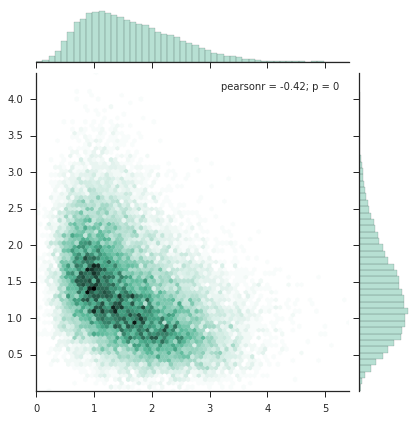

In [8]:
sns.set(style="ticks")

x = neg_evi * -1
y = pos_evi

sns.jointplot(x, y, kind="hex", color="#4CB391")

## Most Significant Features

In [49]:
ws = np.argsort(evis)

print("Top Positive Features")
print(" ".join(["{} ({})".format(feature_names[i], clf.feature_count_[:,i])
                for i in ws[-10:][::-1]]))

print("\nTop Negative Features")
print(" ".join(["{} ({})".format(feature_names[i], clf.feature_count_[:,i])
                for i in ws[:10]]))

Top Positive
paulie ([  0.0572581   11.62001835]) edie ([ 0.          9.50310828]) antwone ([ 0.          7.72889767]) matthau ([  0.78248313  13.0938614 ]) goldsworthy ([ 0.          6.79732636]) din ([ 0.          6.77401576]) victoria ([  1.0431436   13.36768916]) wonderfully ([  2.47759161  22.57390329]) felix ([ 0.48385479  9.01038775]) gundam ([ 0.19220119  7.0279382 ])

Top Negative
waste ([ 101.13224211    5.46404149]) worst ([ 145.77726278   10.81685456]) pointless ([ 34.66318443   2.24914225]) seagal ([ 13.48847522   0.32485711]) boll ([ 10.67268495   0.0988785 ]) unfunny ([ 21.58484167   1.14247772]) awful ([ 97.85823623   8.45586203]) mst3k ([ 15.01247428   0.64075814]) unwatchable ([ 10.95370109   0.24189979]) stinker ([ 10.64923928   0.23665215])


## Most Negative Sample

In [9]:
i = tis.most_negatives()[0]
display(ColoredWeightedDoc(test_corpus[i], feature_names, clf.get_weights()))
samples.append(X_train[i])

## Most Positive Sample

In [11]:
i = tis.most_positives()[0]
display(ColoredWeightedDoc(test_corpus[i], feature_names, clf.get_weights()))
samples.append(X_train[i])

## Least Opinionated Sample

In [12]:
i = tis.least_opinionateds()[0]
display(ColoredWeightedDoc(test_corpus[i], feature_names, clf.get_weights()))
samples.append(X_train[i])

## Most Opinionated Sample

In [13]:
i = tis.most_opinionateds()[0]
display(ColoredWeightedDoc(test_corpus[i], feature_names, clf.get_weights()))
samples.append(X_train[i])

## Most Uncertain Sample

In [14]:
i = tis.most_uncertains()[0]
display(ColoredWeightedDoc(test_corpus[i], feature_names, clf.get_weights()))
samples.append(X_train[i])

## Most Conflicted Sample

In [15]:
i = tis.most_conflicteds()[0]
display(ColoredWeightedDoc(test_corpus[i], feature_names, clf.get_weights()))
samples.append(X_train[i])

## Least Conflicted Sample

In [16]:
i = tis.least_conflicteds()[0]
display(ColoredWeightedDoc(test_corpus[i], feature_names, clf.get_weights()))
samples.append(X_train[i])